# Line Tracing #

## Idea ##

Function: Main
1) Load 1 pixel Image
2) Give every pixel a id
3) Select a Starting Point
Function: Trace Line
1) Check all Pixels surrounding the Starting Point

In [12]:
import utils
import classes
import matplotlib.pyplot as plt
import networkx as nx

In [13]:
imageArray = utils.load1BitBWImage("./../src/testImages/","0.png")
colorImage = utils.loadRGBImage("./../src/testImages/","0.png")

(174, 43)
[165, 50]


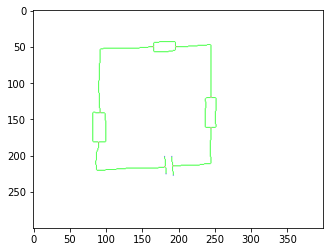

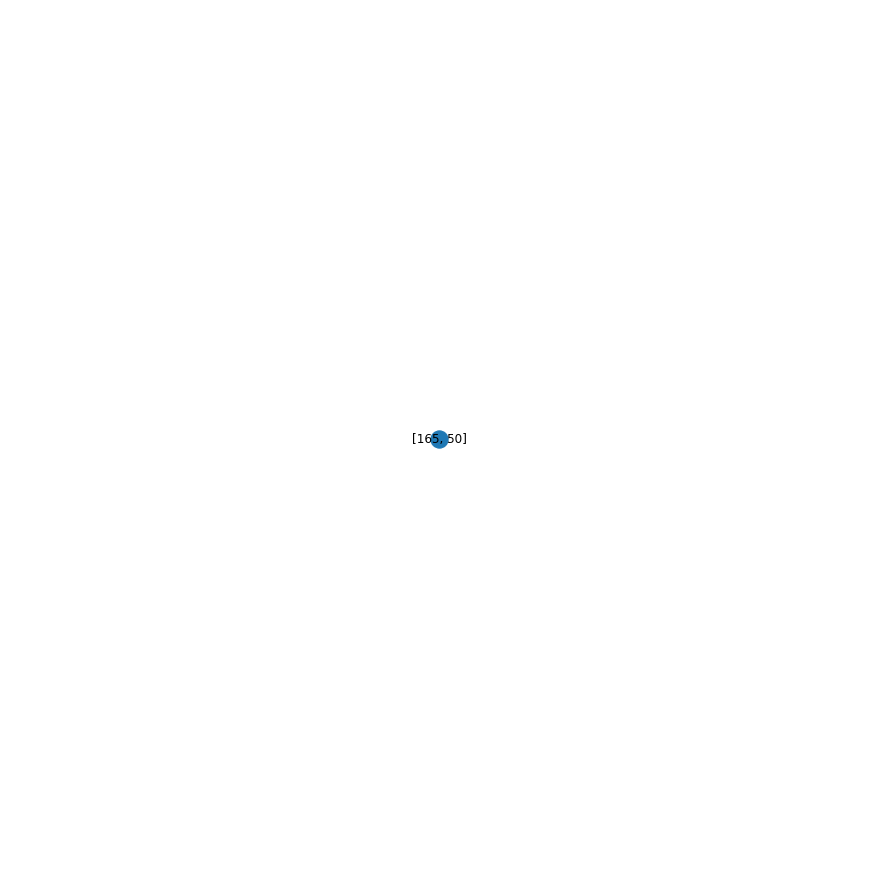

In [16]:
besucht = []
G = nx.MultiDiGraph()

def traceLine(image, currentPixel, pixelBefore,lastEdgePoint, start = -1):
    global besucht,colorImage,G

    
    #start by checking if the current pixel was already visited
    #exit if it has
    if currentPixel in besucht:
        colorImage[currentPixel[1]][currentPixel[0]] = (0,255,0,255)
        if str(currentPixel) in G:
            G.add_edge(lastEdgePoint,str(currentPixel))
        
        return
    besucht.append(currentPixel)


    #Recursive part
    neighbourPixels = [[-1,-1],[0,-1],[1,-1], \
                       [-1,0],        [1,0],  \
                       [-1,1], [0,1], [1,1]]

    validNeighbours=[]
    for neib in neighbourPixels:
        neighbourPixel = [currentPixel[0]+neib[0],currentPixel[1]+neib[1]]
        if image[neighbourPixel[1]][neighbourPixel[0]] == 1:
            if not neighbourPixel == pixelBefore:
                validNeighbours.append(neighbourPixel)

    if len(validNeighbours) > 1:
        if start==0:
            traceLine(image,validNeighbours[0],currentPixel,lastEdgePoint,start=1)
        elif start==1:
            besucht = []
            traceLine(image,currentPixel,None,lastEdgePoint,start=-1)
        else:
            colorImage[currentPixel[1]][currentPixel[0]] = (0,0,255,255)
            G.add_node(str(currentPixel))
            if start == -2: G.add_edge(lastEdgePoint,str(currentPixel))
            for validNeigbour in validNeighbours:
                traceLine(image,validNeigbour,currentPixel,str(currentPixel),start=-2)
    elif len(validNeighbours) == 0:
        if start==0:
            traceLine(image,validNeighbours[0],currentPixel,lastEdgePoint,start=1)
        elif start==1:
            besucht = [currentPixel]
            traceLine(image,currentPixel,None,lastEdgePoint,start=-1)
        else:
            colorImage[currentPixel[1]][currentPixel[0]] = (255,0,0,255)
            G.add_node(str(currentPixel),lenght=1)
            G.add_edge(lastEdgePoint,str(currentPixel))
    else:
        for validNeigbour in validNeighbours:
            traceLine(image,validNeigbour,currentPixel,lastEdgePoint,start)


#traceLine(imageArray,startingPoint,pixelBefore,"",0)
#plt.imshow(colorImage, interpolation='bilinear')

class NodeType():
    pass
class EndNode(NodeType):
    pass
class IntersectionNode(NodeType):
    pass 
class CornerNode(NodeType):
    pass


def getAdjacentPixel(image,currentPixel,blackList):
    #AdjacentPixel Array       
    adjacentPixels = [[-1,-1],[0,-1],[1,-1], \
                        [-1,0],        [1,0], \
                        [-1,1], [0,1], [1,1]]
    validPixels = []
    for adj in adjacentPixels:
        adjacentPixel = [currentPixel[0]+adj[0],currentPixel[1]+adj[1]]
        if image[adjacentPixel[1]][adjacentPixel[0]] == 1:
            if not adjacentPixel in blackList:
                validPixels.append(adjacentPixel)
    return validPixels

# gets first black pixel in image
def findStaringPoint(image):
    for y in range(0,len(image)):
        for x in range(0,len(image)):
            if image[y][x] == 1:
                return (x,y)

## Runs along line until it finds the first Intersection or the first Endpoint
def findValidPoint(image,startPoint):
    #visitedPixel = []
    def recursiveFindValidPoint(currentPixel,lastPixel):
        adjacentPixels = getAdjacentPixel(image,currentPixel,[])
        if len(adjacentPixels) > 2:
            return currentPixel
        adjacentPixels = getAdjacentPixel(image,currentPixel,[lastPixel])    
        return recursiveFindValidPoint(adjacentPixels[0],currentPixel)
    return recursiveFindValidPoint(startPoint,None)

def generateGraph(image,startPoint):
    visitedPixels = []
    graph = nx.MultiDiGraph()
    graph.add_node(str(startPoint))

    def recursiveGenerateGraph(currentPixel,lastPixel,lastGraphNode):

        #End Recursion if loop ends
        if currentPixel in visitedPixels:
            if str(currentPixel) in graph:
                graph.add_edge(lastGraphNode,str(currentPixel))
            return

        visitedPixels.append(currentPixel)
        adjacentPixels = getAdjacentPixel(image,currentPixel,[lastPixel])
        if len(adjacentPixels) == 0:
            #ENDPOINT
            graph.add_node(str(currentPixel),nodeType=EndNode())
            graph.add_edge(lastGraphNode,str(currentPixel))
        elif len(adjacentPixels) == 1:
            #LINE
            recursiveGenerateGraph(adjacentPixels[0],currentPixel,lastGraphNode)
        else:
            #INTERSECTION
            if(str(currentPixel) != lastGraphNode):
                graph.add_node(str(currentPixel),nodeType=IntersectionNode())
                graph.add_edge(lastGraphNode,str(currentPixel))
            for adjacentPixel in adjacentPixels:
                recursiveGenerateGraph(adjacentPixel,currentPixel,str(currentPixel))

    recursiveGenerateGraph(startPoint,None,str(startPoint))
    return graph

startingPoint = findStaringPoint(imageArray)
print(startingPoint)

startingPoint = findValidPoint(imageArray,startingPoint)
print(startingPoint)

G = generateGraph(imageArray,startingPoint)

plt.imshow(colorImage, interpolation='bilinear')
subax1 = plt.figure(121,figsize=(12,12))
nx.draw(G, with_labels=True,connectionstyle='arc3, rad = 0.1')